## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [41]:
#Import all libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns   #visualization

sns.set(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import xgboost as xgb 
from lightgbm import LGBMRegressor

import sys
print (sys.version)

#define most used variables and PROJECT SPECIFIC VARIABLES
RANDOM_STATE=12345
PRINTING_SEPARATOR = '*' * 100
TARGET = 'num_orders'
RMSE_THRESHOLD=48
pd.set_option('display.max_colwidth', -1)

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


In [42]:
#Use it to print separator between the printing information
def PRINT_SEPARATOR():
  print(PRINTING_SEPARATOR)
  print()

In [43]:
#I DEFINED A MACRO FOR "PRINT" and "DISPLAY" FUNCTION using DEBUG FLAG
#If DEBUG=0, the PRINT(), DISPLAY() function will print nothing
#If DEBUG=1, the PRINT(), DISPLAY() function will work like the standard functions

def printNothing(*args):
  pass

DEBUG=0
if (DEBUG):
  print('DEBUG ON')
  PRINT = print
  DISPLAY = display
else:
  print('DEBUG OFF')
  PRINT = printNothing
  DISPLAY = printNothing

DEBUG OFF


## 1.1 CREATE A RESULTS DATAFRAME

In [44]:
#Create a dataframe to dataframe name, Model name and model results
column_names = ['Model','Lag','RollingWindowSize','RMSE_validation','HyperParams']
##Intitialize lists data. 
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams


## 1.2 Data downloading

In [45]:
#Import the file and create the dataset
path = '/datasets'

#Create dataframe to store the source data, index the data on the date column
data = pd.read_csv(path+'/taxi.csv', index_col=[0], parse_dates=[0])   #taxi dataset download
data.sort_index(inplace=True)  # sort based on index

In [46]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    PRINT_SEPARATOR()
    print('Tail:')
    print()
    display(df.tail())
    print('Info:')
    print()
    display(df.info())
    PRINT_SEPARATOR()
    print('Describe:')
    print()
    display(df.describe())
    PRINT_SEPARATOR()
    print('Skew Factor')
    print(df.skew())
    PRINT_SEPARATOR()
    print('Columns with nulls:')
    display(get_percent_of_na_df(df,4))
    PRINT_SEPARATOR()
    print('Shape:')
    print(df.shape)
    PRINT_SEPARATOR()
    print('Duplicated:')
    print('Duplicate rows:', df.duplicated().sum(), ', Duplicate percentage:', (df.duplicated().sum() * 100 ) /df.shape[0],'%')
    
def get_percent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

In [47]:
display_information(data)
PRINT_SEPARATOR()

Head:



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


****************************************************************************************************

Tail:



,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

****************************************************************************************************

Describe:



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


****************************************************************************************************

Skew Factor
num_orders    1.396604
dtype: float64
****************************************************************************************************

Columns with nulls:


,Missing Values,Percent of Nulls
num_orders,0,0.0


****************************************************************************************************

Shape:
(26496, 1)
****************************************************************************************************

Duplicated:
Duplicate rows: 26415 , Duplicate percentage: 99.69429347826087 %
****************************************************************************************************



# 2. Analysis

## 2.1  Plot graphs of the data
- Plot the time series graph.
- Index is set to Datetime column.

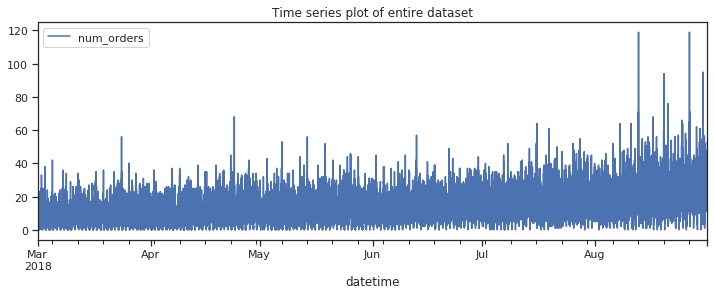

In [48]:
data.plot(figsize=(12,4),title='Time series plot of entire dataset');

### 2.2  Check if datetime in chronological order.

In [49]:
print(data.index.is_monotonic)

True


## CONCLUSION
- The attribute .is_monotonic is true, so the date-times are in chronological order.

###  2.3  Resample the data by hour and plot the graph.
- Regroup the data by 1H (1Hour), currently it is every 10 minutes.
- Calculate the number of taxi rides for 1 Hour

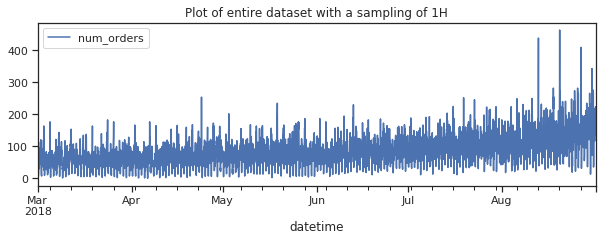

In [50]:
data = data.resample('1H').sum()
data.plot(figsize=(10,3),title='Plot of entire dataset with a sampling of 1H')

###  2.4  Analyse using graphs for resampled data
- Select the 2 week time period for analysis, and plot the time series graph

In [51]:
dataWeek = data['2018-03-01':'2018-03-14']
dataDay = data['2018-03-02']

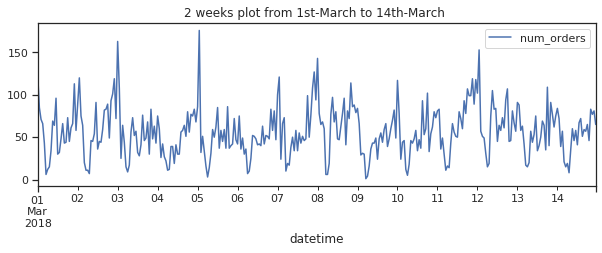

In [52]:
dataWeek.plot(figsize=(10,3),title='2 weeks plot from 1st-March to 14th-March ');

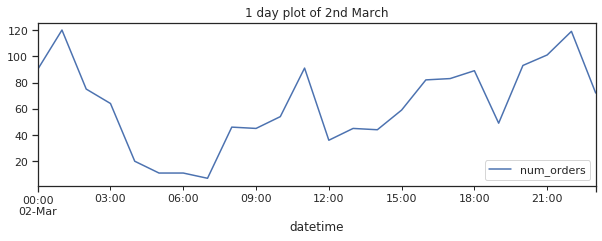

In [53]:
dataDay.plot(figsize=(10,3),title='1 day plot of 2nd March');

## 2.5 Rolling Mean
- Rolling mean or moving average to smooth the data in the time series.
- I am using window size of 7.

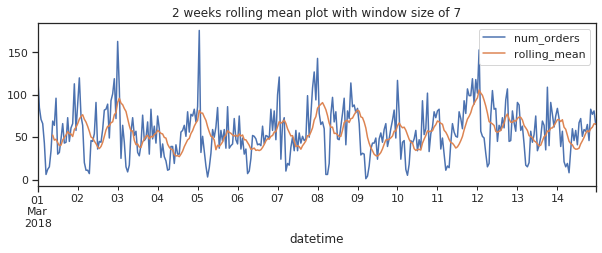

In [54]:
dataWeek['rolling_mean'] = dataWeek.rolling(10).mean() 
dataWeek.plot(figsize=(10,3),title='2 weeks rolling mean plot with window size of 7');

### 2.6  Rolling Standard Deviation with rolling window size of 7.

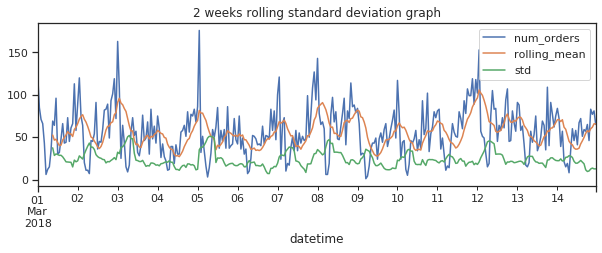

In [55]:
dataWeek['std'] = dataWeek['num_orders'].rolling(10).std() 
dataWeek.plot(figsize=(10,3),title='2 weeks rolling standard deviation graph');

## Conclusion: 
- The Rolling standard deviation depicts that the data has consistent fluctuations.

## 2.7 Daily taxi orders and weekend taxi orders

In [56]:
dataDayHour = dataWeek['2018-03-01']
data2DayHour =  dataWeek['2018-03-02']
dataSaturdayHour = dataWeek[dataWeek.index.weekday==5].head(24)
data2SaturdayHour = dataWeek[dataWeek.index.weekday==5].tail(24)
dataSundayHour = dataWeek['2018-03-04']
data2SundayHour = dataWeek['2018-03-11']

## 2.8  Graphs for 2 different days

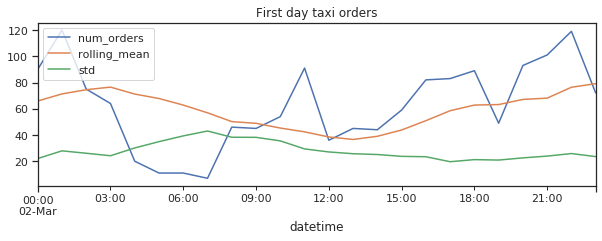

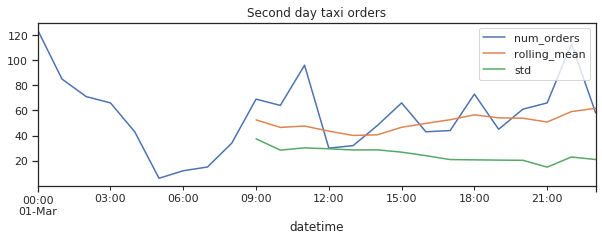

In [57]:
data2DayHour.plot(figsize=(10,3),title='First day taxi orders')
dataDayHour.plot(figsize=(10,3),title='Second day taxi orders')

## 2.9  Graph for 2 consecutive Saturdays 
- To check taxi orders on a weekend Saturday

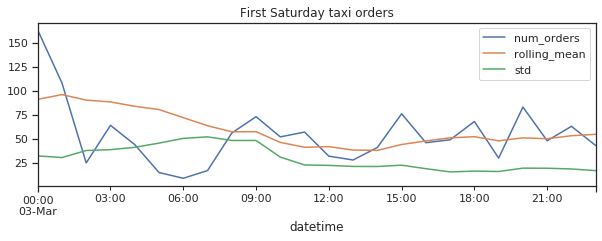

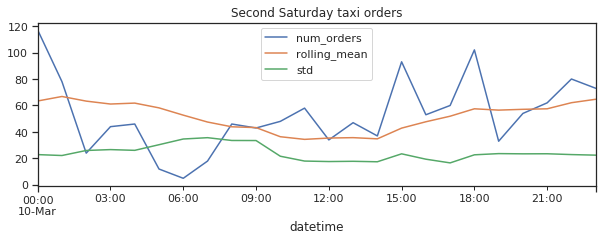

In [58]:
dataSaturdayHour.plot(figsize=(10,3),title='First Saturday taxi orders')
data2SaturdayHour.plot(figsize=(10,3),title='Second Saturday taxi orders')

## 2.10 Graph for 2 consecutive Sundays
- Check taxi orders on 2 consecutive Sundays

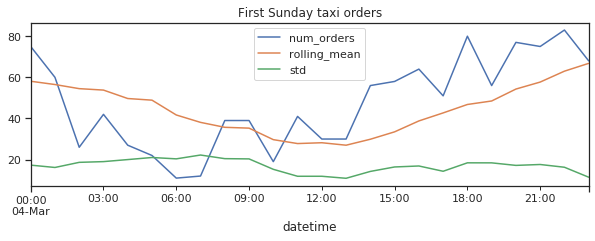

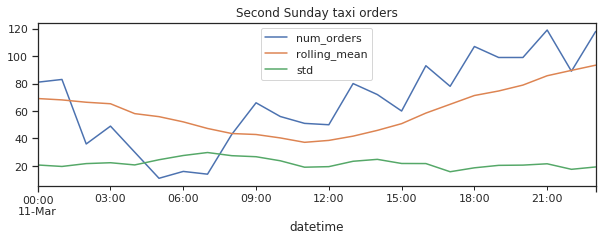

In [59]:
dataSundayHour.plot(figsize=(10,3),title='First Sunday taxi orders')
data2SundayHour.plot(figsize=(10,3),title='Second Sunday taxi orders');

## CONCLUSION
- There is reduced usage of taxi at around 6AM. It starts going up at around 9AM and has dips. Then it goes high again at 18:00 and 21:00. 
- This maybe that people are going to office or business and are using taxis around 9 AM
- People are coming back around 6PM so increase in taxi calls.
- Increase in taxi service at 21:00 (dinner time or dinner parties).
- We need to use use Trends and Seasonality to further understand the Timeseries.

## 2.11 Trends and Seasonality
- A trend is a smooth change of the mean value of the series without repeating patterns. For example, annual increase in taxi rides.
- Seasonality means cyclically repeating patterns in a time series. For instance, the growth of increase in taxi rides on weekdays.

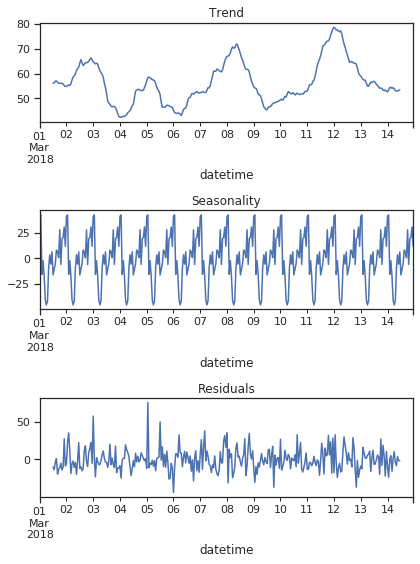

In [60]:
decomposed = seasonal_decompose(dataWeek['num_orders'].dropna())

plt.figure(figsize=(6, 8))
plt.subplot(311)

# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## 2.12 Trends and Seasonality,  2 week-days and a week-end

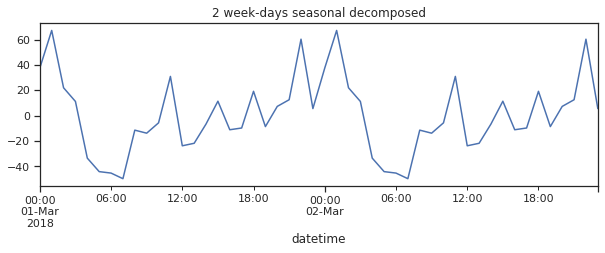

In [61]:
tmp = dataWeek['2018-03-01':'2018-03-02']
decomposed = seasonal_decompose(tmp['num_orders'].dropna())
decomposed.seasonal.plot(figsize=(10,3), title='2 week-days seasonal decomposed');

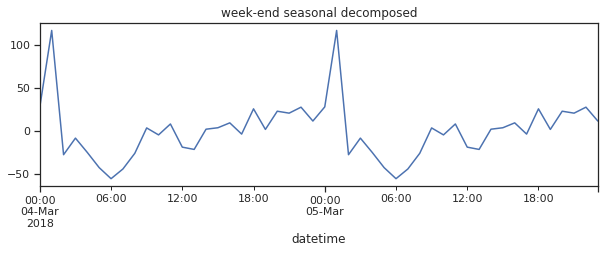

In [62]:
tmp = dataWeek['2018-03-04':'2018-03-05']
decomposed = seasonal_decompose(tmp['num_orders'].dropna())
decomposed.seasonal.plot(figsize=(10,3),title='week-end seasonal decomposed');

### CONCLUSION
- The seasonal plot for week-days and week-end displays similar demand for taxi rides. 
- The taxi rides start decreasing after midnight.
- They start increasing at 6am.
- They peak around noon, then before midnight.

## 2.13  Identify if series is stationary using Time Series Difference
- Lets shift the data, compute the difference, and plot.
- Find the rolling mean, rolling standard deviation for the Time series difference.


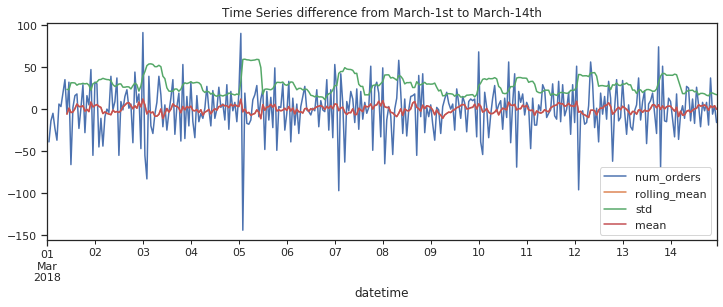

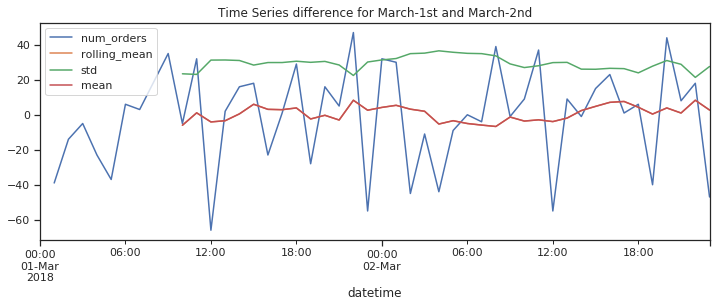

In [63]:
dataWHNew = dataWeek - dataWeek.shift() # < write code here >
dataWHNew['mean'] = dataWHNew['num_orders'].rolling(10).mean()
dataWHNew['std'] = dataWHNew['num_orders'].rolling(10).std()
dataDHNew = dataWHNew['2018-03-01':'2018-03-02']
dataWHNew.plot(figsize=(12,4),title = 'Time Series difference from March-1st to March-14th')
dataDHNew.plot(figsize=(12,4),title = 'Time Series difference for March-1st and March-2nd');

## CONCLUSION

- This seems like Stationary series because the STD and Mean do not change much.
- We should be able to forecast taxi service since this seems like Stochastic series.

# 3. Training

## 3.1  Forecast Accuracy 
-  Evaluate the model  by using the previous value in the series.
-  Predict the hourly taxi orders and find the rmse value for this prediction.



In [64]:
display(data.shape)
display(data.head(5),data.tail(5))

(4416, 1)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [65]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

print("Median hourly taxi orders:", test[TARGET].median())
fillNum = train.iloc[len(train)-1][TARGET]
pred_previous = test.shift(fill_value=fillNum)
# Compute the root-mean-square
rmse = np.sqrt(mean_squared_error(test[TARGET],pred_previous))
print("rmse",rmse)

Median hourly taxi orders: 135.0
rmse 58.856486242815066


## CONCLUSION 
This RMSE of 58 serves as a benchmark for model accuracy. We need to get better predictions than this rmse.

## 3.2 Creating Features
- Create features for a one-step forecast horizon.
- Add Lag values, and rolling_mean to data
- The rolling mean feature sets the general trend of the time series.

####  RMSE. Define a function to score RMSE

In [66]:
##RMSE. Define a function to score RMSE
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))
      
rmse_scoring = make_scorer(rmse_scorer)

In [67]:
def updateResults(model_name,lag,RollingWindowSize,rmseValid,HyperParams,df_results):

    resultRowStr= [model_name,lag,RollingWindowSize,rmseValid,HyperParams]
    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    ##append the rows
    df_results=df_results.append(rows,ignore_index=True)
    
    ##check the rows 
    return(df_results)

In [68]:
def evaluateModel(model,features_train,target_train,features_trial,target_trial):
    model.fit(features_train, target_train)
    predicted_trial = model.predict(features_trial)
    rmseTrial = rmse_scorer(target_trial, predicted_trial) 
    return(rmseTrial)

In [69]:
evaluationModels = [
LinearRegression(),
RandomForestRegressor(random_state=RANDOM_STATE),
XGBRegressor(objective='reg:squarederror',random_state=RANDOM_STATE),
LGBMRegressor(random_state=RANDOM_STATE)
]

evaluationModelNames = ['LinearRegression','RandomForestRegressor','XGBRegressor','LightGBMRegressor']
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

def make_arrLags(data, max_lag, rolling_mean_size):
    data1 = data.copy()   
    for lag in range(1, max_lag + 1):
        data1['lag_{}'.format(lag)] = data1[TARGET].shift(lag)

    data1['rolling_mean'] = data1[TARGET].shift().rolling(rolling_mean_size).mean()
    data1.dropna(inplace=True)
    return data1

def get_features(lag,rollingWindowSize):
    data1 = arrLags[rollingWindowSize][lag]
   # DISPLAY(data1.shape,data1.head(1))
    features=data1.drop(TARGET,axis=1)
    target = data1[TARGET]
    return features,target

In [70]:
#make a 2-dimensional array of the dataframes with different values of rollingWindowSize and lag.
# This is done to avoid repeating the make of dataframes for validation and test sets.
rows, cols = (5, 8) 
arrLags = [[data for i in range(cols)] for j in range(rows)] 
for rollingWindowSize in range(1,5):
    for lag in range(1,8):
            arrLags[rollingWindowSize][lag] = make_arrLags(data,lag,rollingWindowSize)

## 3.3 Model Evaluation
- LinearRegression
- RandomForestRegressor
- XGBRegressor
- LGBMRegressor

In [71]:
for rollingWindowSize in range(1,5):
    for lag in range(1,8):
            features,target = get_features(lag,rollingWindowSize)
            
            #SPLIT TRAINING INTO TRAINING (90%), VALIDATION (10%) AND TEST (10%)      
            features_train, features_validtest, target_train, target_validtest = train_test_split(
                    features, target, test_size=0.2, shuffle=False,random_state=RANDOM_STATE)

            features_valid, features_test, target_valid, target_test = train_test_split(
                    features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=RANDOM_STATE)
            
            i=0
            for model in evaluationModels:
                modelName = evaluationModelNames[i]
                hyperParam=''
                rmseValid = evaluateModel(model,features_train, target_train,features_valid,target_valid)
                df_results = updateResults(modelName,lag,rollingWindowSize,rmseValid,"",df_results)
                i=i+1
                
    totsize = len(data)

PRINT_SEPARATOR()
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('valid set: {0:.0%}'.format(len(features_valid)/totsize),features_valid.shape,', valid target :',target_valid.shape)
print('test set: {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target :',target_test.shape)
PRINT_SEPARATOR()
display(df_results)
PRINT_SEPARATOR()

****************************************************************************************************

training set  : 80% (3527, 13) , training target   : (3527,)
valid set: 10% (441, 13) , valid target : (441,)
test set: 10% (441, 13) , test target : (441,)
****************************************************************************************************



,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
0,LinearRegression,1,1,40.965781,
1,RandomForestRegressor,1,1,35.709805,
2,XGBRegressor,1,1,34.355894,
3,LightGBMRegressor,1,1,34.193484,
4,LinearRegression,2,1,41.135898,
...,...,...,...,...,...
107,LightGBMRegressor,6,4,32.690222,
108,LinearRegression,7,4,40.532138,
109,RandomForestRegressor,7,4,33.308004,
110,XGBRegressor,7,4,32.695977,


****************************************************************************************************



## 3.4 feature Validation: 
- TOP 4 best RMSEs 

In [72]:
result_1 = df_results.sort_values('RMSE_validation',ascending=True).head(4)
display(result_1)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,


### CONCLUSION - 
- The above result displays that the LightGBMRegressor has the best RMSEs for different values of Lag and RollingWindowSize.
- XGBRegressor is second best.

## 3.5 feature Validation: 
- List of best RMSEs
- List of 4 Models with RMSEs

In [73]:
result_2 = df_results.sort_values('RMSE_validation',ascending=True).groupby('Model').head(1)
result_3 = result_1.append(result_2).drop_duplicates(keep='first')
display(result_3)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,
25,RandomForestRegressor,7,1,32.976736,
108,LinearRegression,7,4,40.532138,


### CONCLUSION
- The above table indicates the evaluation of 4 regression models.
- Three regression models resulted in RMSE of 31.xx and 32.xx. The lag and RollingWindowSize parameters are listed for each model.
- We can proceed with the evaluation of these models on the test dataset.
- LinearRegression model had a higher RMSE on validation set.
-  RMSE on validation set is lower than the required threshold of 48. 

- Thank you for the feedback. I did Cross-validation with GridSearchCV on 3 models. Please see below. 

# 3.6  CROSS-VALIDATION Identify Best Hyper-parameters for models to get better RMSEs
- LGBMRegressor
- XGBRegressor
- RandomForestRegressor

## 3.7  LightGBMRegressor with GridSearchCV for Best HyperParameters

In [74]:
ts_cv = model_selection.TimeSeriesSplit(2) ## Required since Timeseries dataset

# Using the best parameters for lag and RollingMean for LGBMRegressor
features,target = get_features(7,3)
#SPLIT TRAINING INTO TRAINING (90%), VALIDATION (10%) AND TEST (10%)      
features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=RANDOM_STATE)
            
param_grid =  {
              'num_leaves' : [31,35,40], 
              'learning_rate' : [0.5,0.1],
              'n_estimators' : [150],
              'eval_metric':['RMSE'],
              'random_state' : [RANDOM_STATE],
               'n_jobs':[-1],
              }

LGBM_model = model_selection.GridSearchCV(estimator=LGBMRegressor(), param_grid=param_grid, cv=ts_cv)
LGBM_model.fit(features_train, target_train, verbose=0)

# Print model params
print("Best Params:")
best_params=LGBM_model.best_params_
print(best_params, "\n", "-" * 80)

##Specify the training parameters 
LGBMmodel = LGBM_model.best_estimator_   #(**best_params)
rmseValid   = evaluateModel(LGBMmodel,features_train, target_train,features_valid,target_valid)
print('rmseValid:',rmseValid)

# Append to the list
evaluationModels.append(LGBMmodel)
evaluationModelNames.append('LightGBM with Crossvalidation')
df_results = updateResults('LightGBM with Crossvalidation',7,3,rmseValid,best_params,df_results)

Best Params:
{'eval_metric': 'RMSE', 'learning_rate': 0.1, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 35, 'random_state': 12345} 
 --------------------------------------------------------------------------------
rmseValid: 32.65810700513643


## 3.8  XGBRegressor with GridSearchCV for Best HyperParameters

In [75]:
# Using the best parameters for lag and RollingMean for XGBRegressor
features,target = get_features(7,3)

#SPLIT TRAINING INTO TRAINING (90%), VALIDATION (10%) AND TEST (10%)      
features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=RANDOM_STATE)

param_grid =   {
                'objective':['reg:squarederror'],
                'colsample_bytree': [0.3,0.7],
                'learning_rate':[0.5,0.1],
                'max_depth': [3,5,7], 
                'min_child_weight': [4,6], 
                'n_estimators': [150,175],
                'n_jobs':[-1],
                'alpha': [5,10],
                'seed':[RANDOM_STATE],
                'nfold':[3,5],
                'num_boost_round':[50],
                'early_stopping_rounds':[50],
                'metrics':['rmse'],
                'silent': [1], 
                'subsample': [0.5,0.7]
                }

XGB_model = GridSearchCV(estimator=XGBRegressor(), param_grid =  param_grid,  cv=ts_cv )
XGB_model.fit(features_train, target_train, verbose=0)

# Print model params
print("Best Params:")
best_params=XGB_model.best_params_
print(best_params, "\n", "-" * 80)

##Specify the training parameters 
XGB_model = XGB_model.best_estimator_   
rmseValid   = evaluateModel(XGB_model,features_train, target_train,features_valid,target_valid)
print('rmseValid:',rmseValid)
# Append to the list
evaluationModels.append(XGB_model)
evaluationModelNames.append('XGBRegressor with Crossvalidation')
df_results = updateResults('XGBRegressor with Crossvalidation',7,3,rmseValid,best_params,df_results)

Best Params:
{'alpha': 5, 'colsample_bytree': 0.7, 'early_stopping_rounds': 50, 'learning_rate': 0.1, 'max_depth': 5, 'metrics': 'rmse', 'min_child_weight': 6, 'n_estimators': 150, 'n_jobs': -1, 'nfold': 3, 'num_boost_round': 50, 'objective': 'reg:squarederror', 'seed': 12345, 'silent': 1, 'subsample': 0.7} 
 --------------------------------------------------------------------------------
rmseValid: 32.396917804209934


## 3.9  Random Forest Regressor  with GridSearchCV for - Best HyperParameters

In [76]:
# Using the best parameters for lag and RollingWindow_size for RandomForestRegressor

features,target = get_features(7,1)

#SPLIT TRAINING INTO TRAINING (90%), VALIDATION (10%) AND TEST (10%)      
features_train, features_validtest, target_train, target_validtest = train_test_split(
           features, target, test_size=0.2, shuffle=False,random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
           features_validtest, target_validtest, test_size=0.5, shuffle=False,random_state=RANDOM_STATE)

param_grid=  {
            'n_estimators': [145,150],
            'criterion':['mse'],
            'n_jobs':[-1],
            'min_samples_leaf': [1,2,4],
            'min_samples_split': [2],
            'random_state':[RANDOM_STATE]
        }

RFR_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid =  param_grid,  cv=ts_cv)
RFR_model.fit(features_train, target_train)

# Print model params
print("Best Params:")
best_params=RFR_model.best_params_
print(best_params, "\n", "-" * 80)

##Specify the training parameters 
RFR_model = RFR_model.best_estimator_  #RandomForestRegressor(**best_params)
rmseValid   = evaluateModel(RFR_model,features_train, target_train,features_valid,target_valid)
print('rmse:',rmseValid)
# Append to the list
evaluationModels.append(RFR_model)
evaluationModelNames.append('RandomForestRegressor with Crossvalidation')
df_results = updateResults('RandomForestRegressor with Crossvalidation',7,1,rmseValid,best_params,df_results)

Best Params:
{'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 12345} 
 --------------------------------------------------------------------------------
rmse: 32.55233337045014


In [77]:
df_resultsFinal = result_3.append(df_results.tail(3)).sort_values(by='RMSE_validation')

In [78]:
display(df_resultsFinal)

,Model,Lag,RollingWindowSize,RMSE_validation,HyperParams
83,LightGBMRegressor,7,3,31.975075,
111,LightGBMRegressor,7,4,32.028683,
82,XGBRegressor,7,3,32.115494,
27,LightGBMRegressor,7,1,32.289539,
113,XGBRegressor with Crossvalidation,7,3,32.396918,"{'alpha': 5, 'colsample_bytree': 0.7, 'early_stopping_rounds': 50, 'learning_rate': 0.1, 'max_depth': 5, 'metrics': 'rmse', 'min_child_weight': 6, 'n_estimators': 150, 'n_jobs': -1, 'nfold': 3, 'num_boost_round': 50, 'objective': 'reg:squarederror', 'seed': 12345, 'silent': 1, 'subsample': 0.7}"
114,RandomForestRegressor with Crossvalidation,7,1,32.552333,"{'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 12345}"
112,LightGBM with Crossvalidation,7,3,32.658107,"{'eval_metric': 'RMSE', 'learning_rate': 0.1, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 35, 'random_state': 12345}"
25,RandomForestRegressor,7,1,32.976736,
108,LinearRegression,7,4,40.532138,


### CONCLUSION:
- LightGBMRegressor, XGBRegressor and RandomForestRegressor are close candidates with validation RMSEs in the range of 31.xx to 22.xx
- Results of cross-validation along with the Hyperparameters are shown.
- We will evaluate all of them on the test dataset.

# 4. Testing

### 4.1 Test Models on the Test dataset
-- Use the results from the validation 

-- Pick the best parameters of Lag, Rolling Window Size for each model from the validation models.

-- Create the feature and test sets using the new Lag and RollingMean Window size.

-- This time, we create feature and test set, and re-tune the model on the features, then use it on prediction for the test target.

-- Test the models with the parameters for Lag, RollingWindow. For cross-validation models, also add Hyperparameters for evaluation.



In [79]:
df_resultsFinal.insert(4,'RMSE_test','')
df_resultsFinal.insert(5,'RMSE_Less_Than_48','')
df_resultsFinal['RMSE_test'] = np.nan
df_resultsFinal.reset_index(drop=True,inplace=True)
for i, row in df_resultsFinal.iterrows():
  modelName = row.Model

  features,target = get_features(row.Lag,row.RollingWindowSize)
           
  #SPLIT TRAINING INTO TRAINING (90%), AND TEST (10%)      
  features_train, features_test, target_train, target_test = train_test_split(
          features, target, test_size=0.1, shuffle=False,random_state=RANDOM_STATE)

  evalModel = evaluationModels[evaluationModelNames.index(modelName)]          
  rmseTest   = evaluateModel(evalModel,features_train, target_train,features_test,target_test)
  PRINT(modelName,'rmse:',rmseTest,'Lag: ',row.Lag,'RollingMean:',row.RollingWindowSize)
  df_resultsFinal.at[i,'RMSE_test'] = rmseTest

PRINT_SEPARATOR()
PRINT('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
PRINT('test set: {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target :',target_test.shape)
df_resultsFinal['RMSE_Less_Than_48'] = np.where(df_resultsFinal['RMSE_test'] < RMSE_THRESHOLD,'Pass','Fail')

dfFinal = df_resultsFinal.sort_values(by='RMSE_test').reset_index(drop=True)
display(dfFinal)
PRINT_SEPARATOR()

****************************************************************************************************



,Model,Lag,RollingWindowSize,RMSE_validation,RMSE_test,RMSE_Less_Than_48,HyperParams
0,LightGBM with Crossvalidation,7,3,32.658107,42.250058,Pass,"{'eval_metric': 'RMSE', 'learning_rate': 0.1, 'n_estimators': 150, 'n_jobs': -1, 'num_leaves': 35, 'random_state': 12345}"
1,XGBRegressor with Crossvalidation,7,3,32.396918,42.747956,Pass,"{'alpha': 5, 'colsample_bytree': 0.7, 'early_stopping_rounds': 50, 'learning_rate': 0.1, 'max_depth': 5, 'metrics': 'rmse', 'min_child_weight': 6, 'n_estimators': 150, 'n_jobs': -1, 'nfold': 3, 'num_boost_round': 50, 'objective': 'reg:squarederror', 'seed': 12345, 'silent': 1, 'subsample': 0.7}"
2,LightGBMRegressor,7,1,32.289539,42.972228,Pass,
3,LightGBMRegressor,7,3,31.975075,43.020483,Pass,
4,LightGBMRegressor,7,4,32.028683,43.618838,Pass,
5,RandomForestRegressor with Crossvalidation,7,1,32.552333,44.286188,Pass,"{'criterion': 'mse', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 12345}"
6,RandomForestRegressor,7,1,32.976736,46.574662,Pass,
7,XGBRegressor,7,3,32.115494,47.200595,Pass,
8,LinearRegression,7,4,40.532138,52.739885,Fail,


****************************************************************************************************



## FINAL CONCLUSION
- Models with test-RMSEs, validation-RMSEs and Hyperparameters are listed above.
- All models are listed in the order of ranking with the first model as the best with lowest test-RMSE.
- The RMSE_Less_Than_48 column indicates if the model passed the rmse_test threshold of 48.
- Best Model: LightGBMRegressor with Cross Validation and Hyperparameters
- Second Best Model: XGBRegressor with Cross Validation and Hyperparameters
- The Cross-validation models have the best RMSEs in the test set. Although their rating on validation RMSEs was lower, they performed higher when we tuned them on features (combination of feature and valid) and evaluated on test dataset.




# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48